In [1]:
import pandas as pd
import psycopg2
hostname = 'scotland'
dbname = 'cs_mdfps'
username = 'cschiebroek'

In [2]:
df_preds_many_to_many = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/outputs/many_to_many.csv')

In [3]:
# df_preds_many_to_many = df_preds_many_to_many.drop(columns=['confid'])
df_preds_many_to_many['abs_error'] = abs(df_preds_many_to_many['vp'] - df_preds_many_to_many['prediction'])
df_preds_many_to_many
#get the molblocks for these molregnos
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()

sql_query = '''
SELECT
    cs_mdfps_schema.mdfp_experiment_data.conf_id AS conf_id,
    public.conformers.molregno,
    public.conformers.molblock
FROM cs_mdfps_schema.mdfp_experiment_data
INNER JOIN public.conformers
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = public.conformers.conf_id
INNER JOIN cs_mdfps_schema.confid_data
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = cs_mdfps_schema.confid_data.conf_id
'''
cur.execute(sql_query)
results = cur.fetchall()
#make dict from molregno to molblock
results[0] 


(2388,
 2390,
 '[H]C([H])=C1C([H])=C([H])[C@]([H])(C([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C1([H])[H]\n     RDKit          3D\n\n  0  0  0  0  0  0  0  0  0  0999 V3000\nM  V30 BEGIN CTAB\nM  V30 COUNTS 10 10 0 0 0\nM  V30 BEGIN ATOM\nM  V30 1 C 3.504903 0.510746 0.342615 0\nM  V30 2 C 2.305884 -0.017947 0.313519 0\nM  V30 3 C 1.386762 0.217584 1.405386 0\nM  V30 4 C 0.093030 0.307013 1.115199 0\nM  V30 5 C -0.280772 0.156627 -0.302815 0 CFG=2\nM  V30 6 C -1.757313 0.178518 -0.497845 0\nM  V30 7 C -2.426833 -0.952773 0.272219 0\nM  V30 8 C -2.284437 1.506201 -0.002609 0\nM  V30 9 C 0.407432 -1.019146 -0.953583 0\nM  V30 10 C 1.882801 -0.862709 -0.821664 0\nM  V30 END ATOM\nM  V30 BEGIN BOND\nM  V30 1 2 1 2\nM  V30 2 1 2 3\nM  V30 3 2 3 4\nM  V30 4 1 4 5\nM  V30 5 1 5 6 CFG=1\nM  V30 6 1 6 7\nM  V30 7 1 6 8\nM  V30 8 1 5 9\nM  V30 9 1 9 10\nM  V30 10 1 10 2\nM  V30 END BOND\nM  V30 END CTAB\nM  END\n')

In [4]:
from rdkit import Chem
from rdkit.Chem import Descriptors
molregno_to_molblock = {}
for result in results:
    molregno_to_molblock[result[1]] = result[2]
    
molregnos = df_preds_many_to_many['molregno'].tolist()
molblocks = [molregno_to_molblock[molregno] for molregno in molregnos]
mols = [Chem.MolFromMolBlock(molblock) for molblock in molblocks]
n_rotatable_bonds = [Descriptors.NumRotatableBonds(mol) for mol in mols]
df_preds_many_to_many['n_rotatable_bonds'] = n_rotatable_bonds
df_preds_many_to_many

,vp,prediction,confid,molregno,abs_error,n_rotatable_bonds
0,2.325205,2.175572,2388,2390,0.149633,1
1,3.662114,3.430600,1156,13,0.231514,2
2,4.841985,4.881612,1172,29,0.039627,1
3,-4.554329,-3.906625,1163,20,0.647704,0
4,-5.124590,-5.074938,1170,27,0.049651,7
...,...,...,...,...,...,...
14078,1.682409,3.081002,15631,3859,1.398592,1
14079,1.682409,3.098156,15632,3859,1.415747,1
14080,1.682409,3.096302,15633,3859,1.413893,1
14081,1.682409,2.975621,15630,3859,1.293212,1


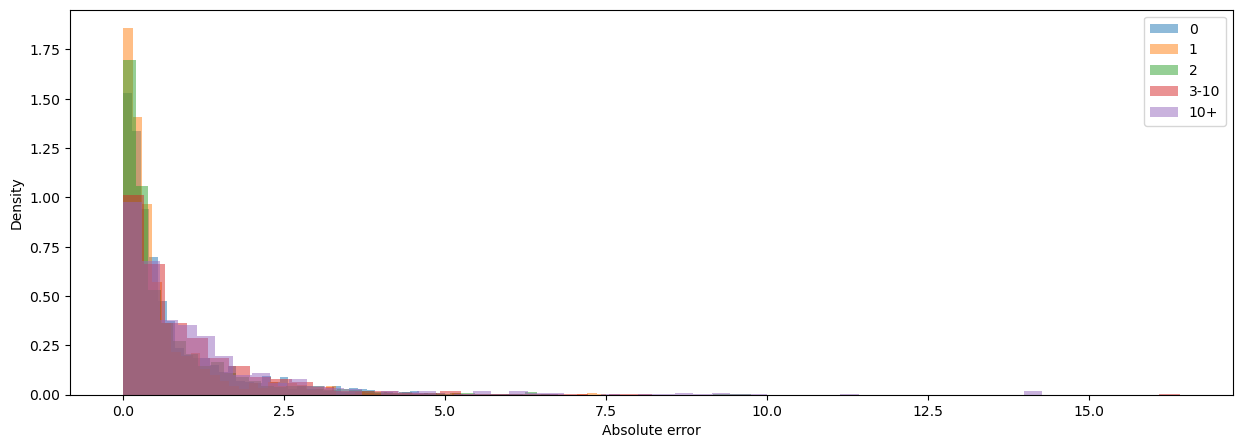

In [5]:
#for each number of rotatable bonds, do a histogram of the absolute errors
#overlay all, make sure everyting is on the same scale
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
#merge together all n_rotatable_bonds > 10
for n in range(4):
    if n < 3:
        df_temp = df_preds_many_to_many[df_preds_many_to_many['n_rotatable_bonds'] == n]
        axs.hist(df_temp['abs_error'], bins=50, label=n, alpha=0.5, density=True)
    else:
        #get df with n_rotatable_bonds > 3 but smaller then 10
        df_temp = df_preds_many_to_many[df_preds_many_to_many['n_rotatable_bonds'] > 3]
        df_temp = df_temp[df_temp['n_rotatable_bonds'] < 10]
        axs.hist(df_temp['abs_error'], bins=50, label="3-10", alpha=0.5, density=True)
        #and bigger then 10
        df_temp = df_preds_many_to_many[df_preds_many_to_many['n_rotatable_bonds'] >= 10]
        axs.hist(df_temp['abs_error'], bins=50, label="10+", alpha=0.5, density=True)

axs.legend()
axs.set_xlabel('Absolute error')
axs.set_ylabel('Density')
plt.show()


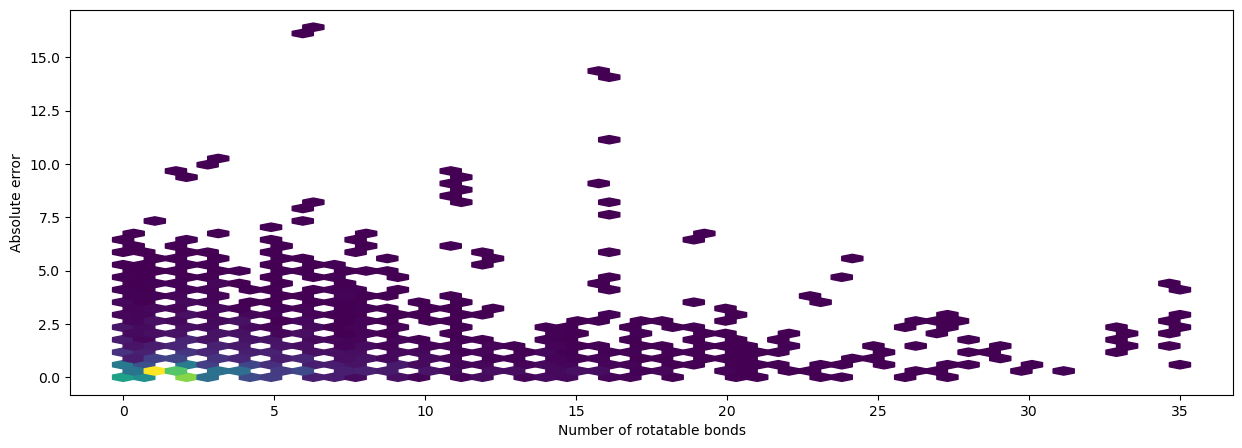

In [6]:
#do hexbin plot of n_rotatable_bonds vs abs_error
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
axs.hexbin(df_preds_many_to_many['n_rotatable_bonds'], df_preds_many_to_many['abs_error'], gridsize=50,mincnt=1)
axs.set_xlabel('Number of rotatable bonds')
axs.set_ylabel('Absolute error')
plt.show()

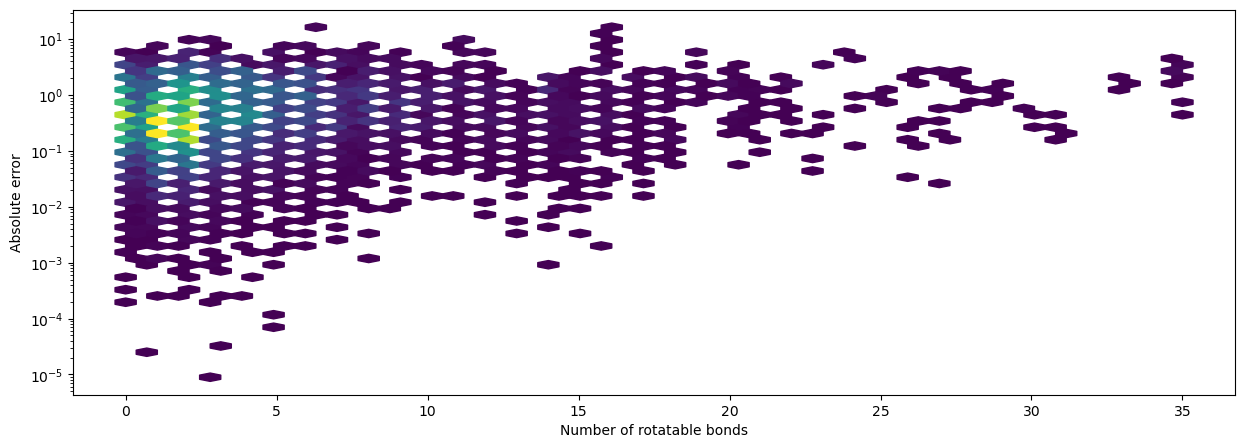

In [7]:
#maybe error on logscale?
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
axs.hexbin(df_preds_many_to_many['n_rotatable_bonds'], df_preds_many_to_many['abs_error'], gridsize=50,mincnt=1, yscale='log')
axs.set_xlabel('Number of rotatable bonds')
axs.set_ylabel('Absolute error')
plt.show()


NameError: name 'np' is not defined

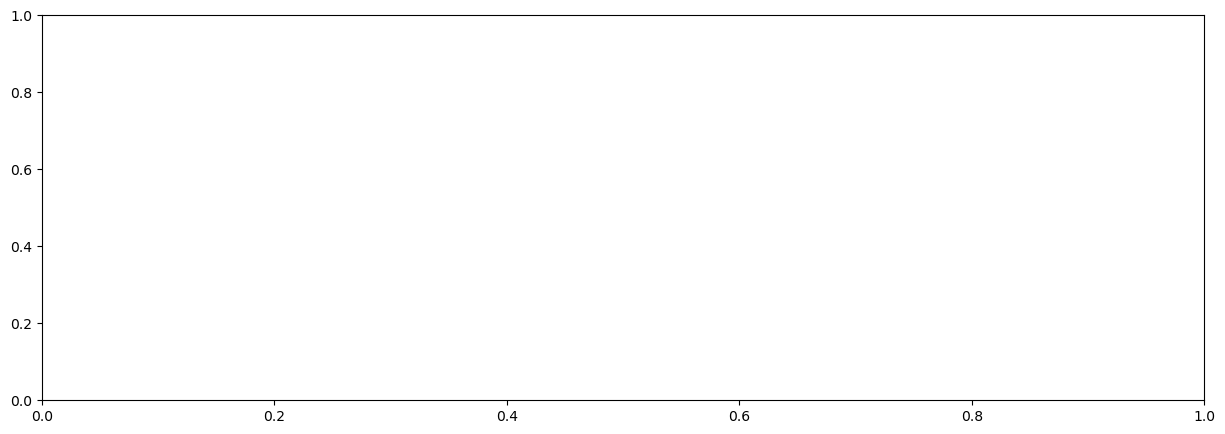

In [8]:
#and bin-wise: for each bin of 1 log unit, plot the mean absolute error
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
vp_bins = np.arange(-22, 10, 1)
vp_bins = [round(vp_bin, 1) for vp_bin in vp_bins]
vp_bins = np.array(vp_bins)
df_preds_many_to_many['vp_bins'] = pd.cut(df_preds_many_to_many['vp'], vp_bins)

#plot bins against mean absolute error
df_temp = df_preds_many_to_many.groupby('vp_bins').agg({'abs_error': ['mean', 'std']})
df_temp = df_temp.reset_index()
df_temp['vp_bins'] = df_temp['vp_bins'].astype(str)

axs.errorbar(df_temp['vp_bins'], df_temp['abs_error']['mean'], yerr=df_temp['abs_error']['std'], fmt='o')
axs.set_xlabel('Experimental vp')
axs.set_ylabel('Mean absolute error')
#set xticks
axs.set_xticks(df_temp['vp_bins'].tolist(), labels = df_temp['vp_bins'].tolist(),rotation=90)  
plt.show()
#barplot better?
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
vp_bins = np.arange(-22, 10, 1)
vp_bins = [round(vp_bin, 1) for vp_bin in vp_bins]
vp_bins = np.array(vp_bins)
df_preds_many_to_many['vp_bins'] = pd.cut(df_preds_many_to_many['vp'], vp_bins)

#plot bins against mean absolute error
df_temp = df_preds_many_to_many.groupby('vp_bins').agg({'abs_error': ['mean', 'std']})
df_temp = df_temp.reset_index()
df_temp['vp_bins'] = df_temp['vp_bins'].astype(str)

axs.bar(df_temp['vp_bins'], df_temp['abs_error']['mean'], yerr=df_temp['abs_error']['std'])
axs.set_xlabel('Experimental vp')
axs.set_ylabel('Mean absolute error of prediction')
#set xticks
axs.set_xticks(df_temp['vp_bins'].tolist(), labels = df_temp['vp_bins'].tolist(),rotation=90)
plt.show()
